In [133]:
import yaml
import pandas as pd
from tqdm import tqdm
from yaspin import yaspin
from yaspin.spinners import Spinners
import ast
import swifter
from datetime import datetime
from socialvec.socialvec import SocialVec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras

tqdm.pandas()

from aux_functions import *

In [147]:

config = "config-political.yaml"

with open(config, 'r') as file:
    conf = yaml.load(file, Loader=yaml.FullLoader)


In [136]:
# read and arrange data
with yaspin(Spinners.arc, text="Reading Data") as sp:
    try:
        data_for_training = pd.read_csv(conf['data_file'])
    except:
        data_for_training = pd.read_csv(conf['data_file'], compression='gzip')
    data_for_training.reset_index(inplace=True)
    data_for_training.drop('index', axis=1, inplace=True)
    data_for_training.drop(data_for_training.columns[data_for_training.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

    data_for_training = data_for_training[data_for_training['source']==conf["source_for_modeling"]]
    data_for_training = data_for_training[~data_for_training['list'].isna()]

0m Reading Data

In [143]:
print("Parsing Lists")
data_for_training['list'] = data_for_training.progress_apply(lambda x: fix_list(x), axis=1)
data_for_training.list = data_for_training.list.swifter.apply(lambda x: list(ast.literal_eval(x.strip())))

Parsing Lists


100%|██████████| 6313/6313 [00:00<00:00, 50630.60it/s]


Pandas Apply:   0%|          | 0/6313 [00:00<?, ?it/s]

In [145]:
data_for_training['list_len']= data_for_training.list.apply(lambda x: len(x))

## filter by pmi

In [ ]:
def filter_relevant_accounts(curr_list):
    return list(set(curr_list).intersection(relevant_accounts))

In [150]:
pmi = pd.read_excel(conf['pmi_file'])

In [156]:
relevant_accounts = set(pmi.account.values)
data_for_training['filtered_list'] = data_for_training['list'].apply(filter_relevant_accounts)
data_for_training['filtered_list_len']= data_for_training.filtered_list.apply(lambda x: len(x))
data_for_training = data_for_training[data_for_training['filtered_list_len']>=10].copy()

/tmp/ipykernel_8668/1315705038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_training['filtered_list'] = data_for_training['list'].apply(filter_relevant_accounts)
/tmp/ipykernel_8668/1315705038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_training['filtered_list_len']= data_for_training.filtered_list.apply(lambda x: len(x))


In [159]:
data_for_training.drop(columns=['list','list_len'], inplace=True)
data_for_training.rename(columns={'filtered_list':'list','filtered_list_len':'list_len'}, inplace=True)

## train test split

In [164]:
if conf["use_existing_train_test_split"] == True:

    print("Using existing train/test split ✅✅")
    df_test_set = pd.read_excel(conf['train_test_split_file'])
    data_for_training = data_for_training.merge(df_test_set, on='twitter_id', how='left')
else:

    print("Creating a new train/test split ‼️‼️")
    # Split the data into train and test sets, stratified by a specific column
    train_df, test_df = train_test_split(data_for_training,
                                         test_size=0.2,
                                         stratify=data_for_training[conf['field_to_classify']])

    # Create a new column 'dataset' and initialize with 'train' for all rows
    data_for_training.loc[data_for_training.index.isin(train_df.index), 'train_test'] = 'train'

    # Use the loc accessor to update the 'dataset' column for the test set rows
    data_for_training.loc[data_for_training.index.isin(test_df.index), 'train_test'] = 'test'

    date_string = datetime.now().strftime("%Y%m%d")
    data_for_training[['twitter_id','train_test']].to_excel(f'../data/{conf["field_to_classify"]}_train_test_split_{date_string}.xlsx', index=False)

Creating a new train/test split ‼️‼️


In [169]:
print(data_for_training['train_test'].value_counts())

train    4656
test     1164
Name: train_test, dtype: int64


In [170]:
sv = SocialVec(conf["SocialVec_version"])
data_for_training[['socialvec', 'socialvec_len']] = data_for_training.progress_apply(lambda x: sv.get_average_embeddings(x['list']), axis=1, result_type='expand' )

✅  Initialize Model5h
✅  Load Metadata[?25h


Pandas Apply:   0%|          | 0/5820 [00:00<?, ?it/s]

In [ ]:
#data_for_training.drop('political_train_test', axis=1, inplace=True)

In [172]:
le = LabelEncoder()
data_for_training['class'] = le.fit_transform(data_for_training[conf['field_to_classify']])
data_for_training = data_for_training[data_for_training['socialvec_len']>conf['minimal_socialvec_len']]
print (f"number of samples after filtering by SocialVec len: {data_for_training.shape[0]}")

number of samples after filtering by SocialVec len: 5773


In [173]:
dict(zip(range(len(le.classes_)), le.classes_))

{0: 'Democrat', 1: 'Republican'}

In [176]:
#data_for_training.drop_duplicates(subset=['twitter_id', 'screen_name', 'name'],inplace=True)

In [177]:
train_df = data_for_training[data_for_training['train_test']=='train'].copy()
test_df = data_for_training[data_for_training['train_test']=='test'].copy()

In [178]:
X_train, y_train     = prep_tf_inputs(train_df, 'socialvec')
X_test,  y_test      = prep_tf_inputs(test_df, 'socialvec')

In [180]:
def label_smoothing_loss(y_true, y_pred, smoothing=0.1):
    """
    Custom loss function implementing label smoothing.
    """
    num_classes = y_true.shape[-1]
    smooth_positives = 1.0 - smoothing
    smooth_negatives = smoothing / num_classes
    y_true = y_true * smooth_positives + smooth_negatives

    return keras.losses.categorical_crossentropy(y_true, y_pred)


## Model Training

In [181]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision

tf.keras.backend.clear_session()

input_shape = (X_train.shape[1],)

# Create the model
model = keras.Sequential()

# Add a Dense layer with 64 units and ReLU activation
model.add(layers.Dense(64, activation='relu', input_shape=input_shape))

# Add a Dense layer with 2 output neurons (representing the two classes) and softmax activation
model.add(layers.Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
                loss= label_smoothing_loss, #'categorical_crossentropy',
                metrics=[Precision()],
                run_eagerly=True)

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 6,594
Trainable params: 6,594
Non-trainable params: 0
_________________________________________________________________


In [182]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# One-dimensional array containing zeros and ones
data = y_train

# Reshape the data to a 2D array with a single feature
data_2d = data.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the data
one_hot_encoded = tf.constant(encoder.fit_transform(data_2d))

In [ ]:
model.fit(X_train,
              one_hot_encoded,
              epochs=100,
              batch_size=50,
              validation_split=0.1,
              verbose=True)

## Load Model and predict

In [ ]:
if conf['load_model']:

    custom_objects = {'label_smoothing_loss': label_smoothing_loss}
    with keras.utils.custom_object_scope(custom_objects):    
        model = keras.models.load_model(f"models/{conf['model_name']}.h5")

In [184]:
preds_full = model.predict(X_test)

37/37 [==============================] - 0s 2ms/step


In [185]:
test_preds = tf.argmax(model.predict(X_test), axis=1)

37/37 [==============================] - 0s 3ms/step


In [186]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       523
           1       0.97      0.97      0.97       634

    accuracy                           0.97      1157
   macro avg       0.97      0.97      0.97      1157
weighted avg       0.97      0.97      0.97      1157



In [187]:
test_df['preds'] = test_preds
test_df['confidence'] = np.max((preds_full), axis=1)

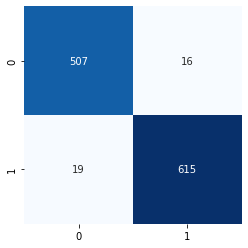

In [188]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# y_test  : actual labels or target
# y_preds : predicted labels or target
sns.heatmap(confusion_matrix(y_test, test_preds),square=True, annot=True, cmap='Blues', fmt='d', cbar=False);

In [189]:
test_df[test_df['confidence']>0.9].groupby('class').count()

,twitter_id,political,political_train_test,source,list,list_len,train_test,socialvec,socialvec_len,preds,confidence
class,,,,,,,,,,,
0,367,367,367,367,367,367,367,367,367,367,367
1,616,616,616,616,616,616,616,616,616,616,616


In [191]:
test_df[test_df['confidence']>0.9].shape[0] / test_df.shape[0]

0.8496110630942092

## High confidence results

In [192]:
test_df['confidence'].mean()

0.92064214

In [193]:
test_df_high_confidence = test_df[test_df['confidence']>0.9].copy()

In [194]:
from sklearn.metrics import classification_report
print(classification_report(test_df_high_confidence['class'], test_df_high_confidence['preds']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       367
           1       0.99      0.98      0.99       616

    accuracy                           0.98       983
   macro avg       0.98      0.98      0.98       983
weighted avg       0.98      0.98      0.98       983



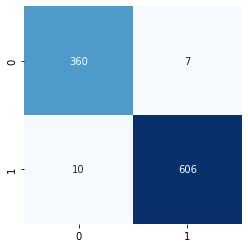

In [195]:
sns.heatmap(confusion_matrix(test_df_high_confidence['class'], test_df_high_confidence['preds']),square=True, annot=True, cmap='Blues', fmt='d', cbar=False);

## Save Model

In [196]:
type(model)

keras.engine.sequential.Sequential

In [197]:
import pickle
from datetime import datetime
# @dataclass
# class ClassificationModel:
#     attribute: str = "Gender"
#     SocialVec_version: str= "2020"
#     model: keras.Sequential = model
#     labels: LabelEncoder = le
#     relevant_accounts: list = field(default_factory=lambda: relevant_accounts)
        
version = datetime.now().strftime('%y%m%d')
    
model_data = {
    'model_type': 'Classification',
    'attribute': 'Political',
    'SocialVec_version': '2020',
    'version': version,
    'model': model,
    'labels': le,
    'relevant_accounts': relevant_accounts,
    'description': 'Political classifier with PMI filtering using SocialVec2020'
}

In [200]:

model_file_path = f"models/{model_data['attribute']}_{model_data['SocialVec_version']}_{datetime.now().strftime('%y%m%d')}.pkl"

with open(model_file_path, 'wb') as file:
    # Save the object using pickle.dump()
    pickle.dump(model_data, file)

## Save the wrong predictions for debug

In [ ]:
test_df_debug = test_df[['twitter_id', 'list', conf["field_to_classify"], 'source', 'train_test',
       'socialvec_len', 'class', 'preds', 'confidence']].copy()

test_df_debug.to_csv(f"{conf['field_to_classify']}_test_df_debug.csv.gz", compression='gzip')

In [ ]:
test_df['confidence'].mean()